<a href="https://colab.research.google.com/github/JayThibs/hyperdrive-vs-automl-plus-deployment/blob/main/hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Tuning using HyperDrive

# Environment and Import Dependencies

Here we specify the conda dependencies.

In [27]:
%%writefile conda_dependencies.yml

dependencies:
- python=3.6.2
- pip=20.2.4
- pandas
- numpy
- pip:
    - azureml-defaults
    - scikit-learn

Overwriting conda_dependencies.yml


In [28]:
from azureml.core import Environment

# Creating a conda environment for model training. It needs to be included in ScriptRunConfig.

sklearn_env = Environment.from_conda_specification(name='sklearn_env', file_path='./conda_dependencies.yml')

In [29]:
!pip install seaborn

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re

import logging
import os
import csv

In [31]:
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.24.0


# Preprocessing

In [32]:
%%writefile feature_preprocessing.py

import numpy as np
import pandas as pd

def bools(df):
    """
    public_meeting: we will fill the nulls as 'False'
    permit: we will fill the nulls as 'False
    """
    z = ['public_meeting', 'permit']
    for i in z:
        df[i].fillna(False, inplace = True)
        df[i] = df[i].apply(lambda x: float(x))
    return df

def locs(df, trans = ['longitude', 'latitude', 'gps_height', 'population']):
    """
    fill in the nulls for ['longitude', 'latitude', 'gps_height', 'population'] by using medians from 
    ['subvillage', 'district_code', 'basin'], and lastly the overall median
    """
    df.loc[df.longitude == 0, 'latitude'] = 0
    for z in trans:
        df[z].replace(0., np.NaN, inplace = True)
        df[z].replace(1., np.NaN, inplace = True)
        
        for j in ['district_code', 'basin']:
        
            df['median'] = df.groupby([j])[z].transform('median')
            df[z] = df[z].fillna(df['median'])
        
        df[z] = df[z].fillna(df[z].median())
        del df['median']
    return df

def construction(df):
    """
    A lot of null values for construction year. Of course, this is a missing value (a placeholder).
    For modeling purposes, this is actually fine, but we'll have trouble with visualizations if we
    compare the results for different years, so we'll set the value to something closer to
    the other values that aren't placeholders. Let's look at the unique years and set the null
    values to 50 years sooner.
    Let's set it to 1910 since the lowest "good" value is 1960.
    """
    df.loc[df['construction_year'] < 1950, 'construction_year'] = 1910
    return df

# Alright, now let's drop a few columns

def removal(df):
  # id: we drop the id column because it is not a useful predictor.
  # amount_tsh: is mostly blank - delete
  # wpt_name: not useful, delete (too many values)
  # subvillage: too many values, delete
  # scheme_name: this is almost 50% nulls, so we will delete this column
  # num_private: we will delete this column because ~99% of the values are zeros.
  features_to_drop = ['id','amount_tsh',  'num_private', 
          'quantity', 'quality_group', 'source_type', 'payment', 
          'waterpoint_type_group', 'extraction_type_group', 'wpt_name', 
          'subvillage', 'scheme_name']
  df = df.drop(features_to_drop, axis=1)

  return df

def dummy(df):
    dummy_cols = ['funder', 'installer', 'basin', 'lga', 'ward', 'public_meeting', 'recorded_by',
        'scheme_management', 'permit', 'extraction_type',
        'extraction_type_class', 'management', 'management_group',
        'payment_type', 'water_quality', 'quantity_group', 'source',
        'source_class', 'waterpoint_type', 'region']

    df = pd.get_dummies(df, columns=dummy_cols)

    return df

def dates(df):
    """
    date_recorded: this might be a useful variable for this analysis, although the year itself would be useless in a practical scenario moving into the future. We will convert this column into a datetime, and we will also create 'year_recorded' and 'month_recorded' columns just in case those levels prove to be useful. A visual inspection of both casts significant doubt on that possibility, but we'll proceed for now. We will delete date_recorded itself, since random forest cannot accept datetime
    """
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['year_recorded'] = df['date_recorded'].apply(lambda x: x.year)
    df['month_recorded'] = df['date_recorded'].apply(lambda x: x.month)
    df['date_recorded'] = (pd.to_datetime(df['date_recorded'])).apply(lambda x: x.toordinal())
    return df

def dates2(df):
    """
    Turn year_recorded and month_recorded into dummy variables
    """
    for z in ['month_recorded', 'year_recorded']:
        df[z] = df[z].apply(lambda x: str(x))
        good_cols = [z+'_'+i for i in df[z].unique()]
        df = pd.concat((df, pd.get_dummies(df[z], prefix = z)[good_cols]), axis = 1)
        del df[z]
    return df

def small_n(df):
    "Collapsing small categorical value counts into 'other'"
    cols = [i for i in df.columns if type(df[i].iloc[0]) == str]
    df[cols] = df[cols].where(df[cols].apply(lambda x: x.map(x.value_counts())) > 100, "other")
    return df

Overwriting feature_preprocessing.py


# Write Training File for our Hyperdrive Model

In [33]:
%%writefile train.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re
import os
from sklearn.metrics import recall_score

import argparse
import joblib
from azureml.core.run import Run

from feature_preprocessing import *

# We loaded the dataset into Azure and we are grabbing it here.
from azureml.core import Workspace, Dataset

# download config file in azure and put it in the current Notebooks folder
ws = Workspace.from_config()

dataset = Dataset.get_by_name(ws, name='Pump-it-Up-dataset')
X = dataset.to_pandas_dataframe()
y = X['status_group']
del X['status_group']

# Cleaning up the features of our dataset
X = bools(X)
X = locs(X)
X = construction(X)
X = removal(X)
X = dummy(X)
X = dates(X)
x = dates2(X)
X = small_n(X)

# Removing ">", "[" and "]" from the headers to make the data compatible with different algorithms (namely, xgboost)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

# Converting the population values to log
X['population'] = np.log(X['population'])

# Splitting the dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

run = Run.get_context()


def main():
    # Adds arguments to script
    parser = argparse.ArgumentParser()

    # Setting the hyperparameters we will be optimizing for you Random Forest model
    parser.add_argument('--max_depth', type=int, default=6, help='The maximum depth of the trees.')
    parser.add_argument('--min_samples_split', type=int, default=4, help='The minimum number of samples required to split an internal node.')
    parser.add_argument('--n_estimators', type=int, default=750, help='The number of trees in the forest.')

    args = parser.parse_args()

    run.log("Max depth of the trees:", np.int(args.max_depth))
    run.log("Minimum number of samples required to split:", np.int(args.min_samples_split))
    run.log("Number of trees:", np.int(args.n_estimators))

    # Fitting a Random Forest model to our data. 
    # Sidenote: I also tried XGBoost on my local machine, but it did not perform as well.
    # RF has a score of 0.811, XGBoost has a score of 0.745
    # Since I did not use a validation set, it's possible that I'm just overfitting with RF.
    # But I wanted to focus on the end-to-end process for this project so I didn't bother with 
    # a validation set.
    rf = RandomForestClassifier(max_depth=args.max_depth,
                                min_samples_split=args.min_samples_split,
                                n_estimators=args.n_estimators,
                                criterion='gini',
                                oob_score=True,
                                random_state=42,
                                n_jobs=-1).fit(X_train, y_train.values.ravel())
    
    # Predicting on the test set
    predictions = rf.predict(X_test)
    pred = pd.DataFrame(predictions)

    # Calculate recall to test how well we do on True Positives
    # We can imagine a real scenario where we want to build a model
    # that does not miss the non-functioning water pumps, and we
    # care much less functioning water pumps that are incorrectly
    # predicted as non-functional. 
    recall = recall_score(y_test, pred, average='micro')
    run.log("Recall", np.float(recall))

    os.makedirs('outputs', exist_ok=True)
    joblib.dump(rf, 'outputs/rf_model.pkl')

if __name__ == '__main__':
    main()

Overwriting train.py


# Dataset

Getting our data and initialize a workspace object from persisted configuration. We placed the config file in .\config.json.

In [34]:
from azureml.core import Workspace, Experiment, Dataset

# download config file in azure and put it in the current Notebooks folder
ws = Workspace.from_config()
exp = Experiment(workspace=ws, name="Pump-it-Up-Data-Mining-the-Water-Table")

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = exp.start_logging()

Workspace name: quick-starts-ws-142332
Azure region: southcentralus
Subscription id: 1b944a9b-fdae-4f97-aeb1-b7eea0beac53
Resource group: aml-quickstarts-142332


In [35]:
# If you get an error during training and try to rerun this cell, it may get stuck in execution.
# I'm not sure what's the issue, but it gets resolved by stopping compute before rerunning the notebook.
dataset = Dataset.get_by_name(ws, name='Pump-it-Up-dataset')
X = dataset.to_pandas_dataframe()
y = X['status_group']
del X['status_group']

# Data Exploration

Before we dive into training the model with our train.py script, let's do a bit of data exploration to see the steps we took to preprocess the data to prepare it for training.

In [36]:
# Looking at statistics from the training data
# The mean for construction year is definitely off. Looks like there might 
# be a lot of 0 values if we look at the min and 25% rows.
# We can see the same issue for some of the other columns.
X.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59396.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.671762,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.674361,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


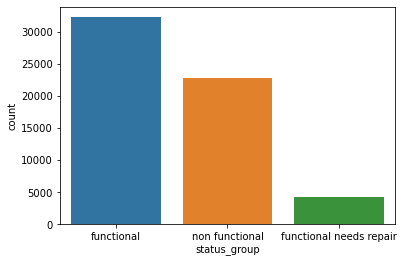

In [37]:
# Looking at the class distribution
sns.countplot(y)

In [38]:
# Percentage of each class
y.value_counts(normalize = True) * 100

functional                 54.308081
non functional             38.424242
functional needs repair     7.267677
Name: status_group, dtype: float64

In [39]:
X.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [40]:
# Let's check to see if any of the categorical columns follow an order (e.g. from low to high)
# Spoiler alert: they don't
X['quality_group'].unique()

array(['good', 'salty', 'milky', 'unknown', 'fluoride', 'colored'],
      dtype=object)

In [41]:
X['quantity'].unique()

array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
      dtype=object)

In [42]:
# Number of unique values per column
# For categorical values, this is the number of classes
print('Total number of examples: ' + str(len(X)))
X.nunique().sort_values()

Total number of examples: 59400


recorded_by                  1
permit                       2
public_meeting               2
source_class                 3
quantity_group               5
quantity                     5
management_group             5
quality_group                6
waterpoint_type_group        6
source_type                  7
payment_type                 7
payment                      7
waterpoint_type              7
extraction_type_class        7
water_quality                8
basin                        9
source                      10
scheme_management           12
management                  12
extraction_type_group       13
extraction_type             18
district_code               20
region                      21
region_code                 27
construction_year           55
num_private                 65
amount_tsh                  96
lga                        125
date_recorded              356
population                1049
funder                    1897
ward                      2092
installe

In [43]:
# Let's check the number of null values for construction_year
len(X[X.construction_year == 0])

20709

In [44]:
# Alright, let's set it to 1910 because the earliest non-null year is 1960.
X.loc[X['construction_year'] < 1950, 'construction_year'] = 1910

In [45]:
# These are the columns we will be dropping in order to improve training
features_to_remove = ['id','amount_tsh',  'num_private', 
          'quantity', 'quality_group', 'source_type', 'payment', 
          'waterpoint_type_group', 'extraction_type_group', 'wpt_name', 
          'subvillage', 'scheme_name']
X = X.drop(features_to_remove, axis=1)
X.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,...,extraction_type,extraction_type_class,management,management_group,payment_type,water_quality,quantity_group,source,source_class,waterpoint_type
0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,...,gravity,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe
1,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,20,2,...,gravity,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe
2,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,21,4,...,gravity,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple
3,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,...,submersible,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple
4,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,18,1,...,gravity,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe


In [46]:
# Need to check which features are objects and then use pd.get_dummies 
# to turn the features into numerical categories for random forest to work
X.columns[X.dtypes==object]

Index(['funder', 'installer', 'basin', 'region', 'lga', 'ward',
       'public_meeting', 'recorded_by', 'scheme_management', 'permit',
       'extraction_type', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity_group',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object')

In [47]:
dummy_cols = ['funder', 'installer', 'basin', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type', 'region']

In [48]:
# convert strings into numerical values
# We can see that this dramatically increases the number of features, this is fine
pd.get_dummies(X, columns=dummy_cols)

,date_recorded,gps_height,longitude,latitude,region_code,district_code,population,construction_year,funder_0,funder_A/co Germany,...,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga
0,2011-03-14,1390,34.938093,-9.856322,11,5,109,1999,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-03-06,1399,34.698766,-2.147466,20,2,280,2010,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-02-25,686,37.460664,-3.821329,21,4,250,2009,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-28,263,38.486161,-11.155298,90,63,58,1986,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2011-07-13,0,31.130847,-1.825359,18,1,0,1910,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,2013-05-03,1210,37.169807,-3.253847,3,5,125,1999,0,0,...,0,0,0,0,0,0,0,0,0,0
59396,2011-05-07,1212,35.249991,-9.070629,11,4,56,1996,0,0,...,0,0,0,0,0,0,0,0,0,0
59397,2011-04-11,0,34.017087,-8.750434,12,7,0,1910,0,0,...,0,0,0,0,0,0,0,0,0,0
59398,2011-03-08,0,35.861315,-6.378573,1,4,0,1910,0,0,...,0,0,0,0,0,0,0,0,0,0


# On to Training the Model!

# But first: Setting up our Compute Target

In [49]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Creating a compute cluster if there isn't one that is already created.

cpu_cluster_name = 'hypr-auto-clustr'

try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new computer target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_v2',
                                                          max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
    
cpu_cluster.wait_for_completion(show_output=True)

Creating a new computer target...
Creating...
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [50]:
# Using get_status() to get a detailed status for the current compute cluster.
print(cpu_cluster.get_status().serialize())

{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-04-10T17:27:07.899000+00:00', 'errors': None, 'creationTime': '2021-04-10T17:27:05.363963+00:00', 'modifiedTime': '2021-04-10T17:27:20.799100+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


In [51]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

notebook142332 ComputeInstance Succeeded
hypr-auto-clustr AmlCompute Succeeded


In [52]:
cpu_cluster

AmlCompute(workspace=Workspace.create(name='quick-starts-ws-142332', subscription_id='1b944a9b-fdae-4f97-aeb1-b7eea0beac53', resource_group='aml-quickstarts-142332'), name=hypr-auto-clustr, id=/subscriptions/1b944a9b-fdae-4f97-aeb1-b7eea0beac53/resourceGroups/aml-quickstarts-142332/providers/Microsoft.MachineLearningServices/workspaces/quick-starts-ws-142332/computes/hypr-auto-clustr, type=AmlCompute, provisioning_state=Succeeded, location=southcentralus, tags=None)

# Hyperdrive Configuration

We are using Random Forest to train our model. We will use Hyperdrive to do a hyperparameter search to optimize our model.

We will be using Random Sampling since it is more efficient than grid search for finding an optima.



In [53]:
from azureml.widgets import RunDetails
from azureml.core import ScriptRunConfig
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.sampling import BayesianParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import quniform
from azureml.train.hyperdrive.parameter_expressions import choice
import os

# Specifying parameter sampler.
# - Here we use Bayesian Hyperparameter Sampling to search the hyperparameter space for the best model.
# - Essentially, Bayesian Sampling builds a probability model of the objective function we are trying 
#   to minimize and uses it to select the most promising hyperparameters to evaluate in the true objective function.
# - For best results with Bayesian Sampling we recommend using a maximum number of runs greater than or 
#   equal to 20 times the number of hyperparameters being tuned. Recommendend value:60.
#   We will be optimizing 3 hyperparameters for this project, therefore we choose 60 max_total_runs.
# - We also use quniform to search the hyperparameter space since quniform(low, high, q) creates uniform distriution 
#   between low and high values, separated by spacing q.

ps = BayesianParameterSampling(
    {
    'max_depth': quniform(3, 12, 3), # Maximum depth of the trees, (3, 6, 9, 12)
    'min_samples_split': choice(4, 6), # Minimum number of samples required to split
    'n_estimators' : choice(500, 750, 1000) # Number of trees
    }
)

if "training" not in os.listdir():
    os.mkdir("./training")

# Creating a SKLearn estimator for use with train.py
src = ScriptRunConfig(source_directory=os.path.join('./'),
                      script='train.py',
                      compute_target=cpu_cluster,
                      environment=sklearn_env)

# Creating a HyperDriveConfig using the estimator, hyperparameter sampler, and policy.
hyperdrive_config = HyperDriveConfig(run_config=src,
                                    hyperparameter_sampling=ps,
                                    primary_metric_name='norm_macro_recall',
                                    primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                    max_total_runs=60,
                                    max_concurrent_runs=4)

# Submit Experiment and Run Details

In [54]:
# Submitting a HyperDrive run to the experiment and show run details with the widget.

hyperdrive_run = exp.submit(config=hyperdrive_config)

RunDetails(hyperdrive_run).show()
hyperdrive_run.wait_for_completion(show_output=True)

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

RunId: HD_dc5fbae1-c351-4a54-adf2-65b7ffdd25c2
Web View: https://ml.azure.com/experiments/Pump-it-Up-Data-Mining-the-Water-Table/runs/HD_dc5fbae1-c351-4a54-adf2-65b7ffdd25c2?wsid=/subscriptions/1b944a9b-fdae-4f97-aeb1-b7eea0beac53/resourcegroups/aml-quickstarts-142332/workspaces/quick-starts-ws-142332

Streaming azureml-logs/hyperdrive.txt

"<START>[2021-04-10T17:27:33.363190][API][INFO]Experiment created<END>\n""<START>[2021-04-10T17:27:33.908926][GENERATOR][INFO]Trying to sample '4' jobs from the hyperparameter space<END>\n""<START>[2021-04-10T17:27:35.202834][GENERATOR][INFO]Successfully sampled '4' jobs, they will soon be submitted to the execution target.<END>\n"


# Saving our Best Random Forest / Hyperdrive Model

In [ ]:
import joblib
# Get your best run and save the model from that run.

best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()

print('Best Run:', best_run)
print('Metrics:', best_run_metrics['recall_score_micro'])

hyperdrive_model = best_run.register_model(model_name="rf_hyperdrive_model", model_path="./outputs/model.pkl")